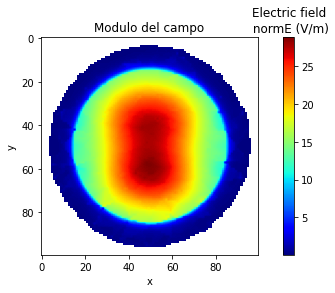

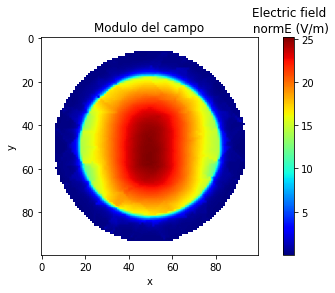

['Ex', 'Ey', 'Ez', 'normE', 'Ephi', 'Etheta', 'Enorm']


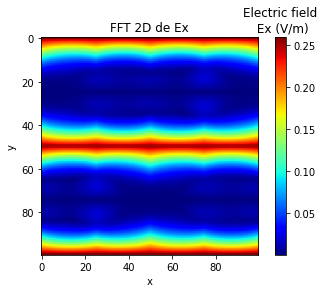

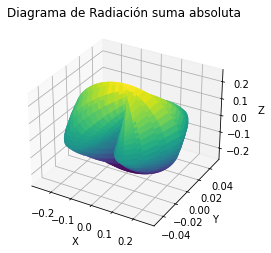

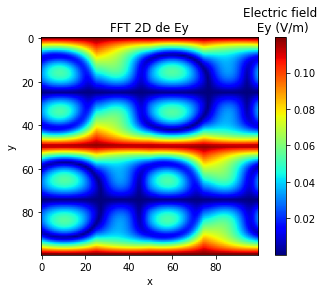

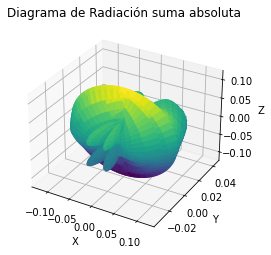

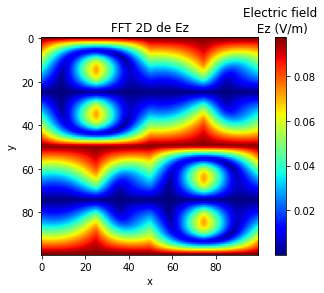

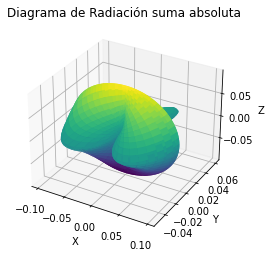

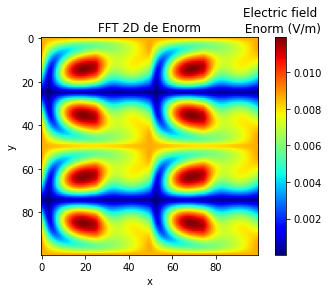

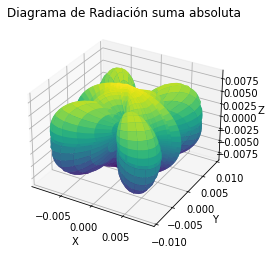

In [5]:
__author__ = "joseluis"

import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator
from mpl_toolkits.mplot3d import Axes3D

#VARIABLES GLOBALES
mu0           = 4*np.pi*1e-7
c0            = 299792458
raw_data      = 9
pauseinterval = 0.01

k0 ,delta_x,L_x,delta_y,L_y,coordz = 0,0,0,0,0,0
flow_config = { 'directory':r'C:\\Users\\aitor\\OneDrive\\Desktop\\TFG-AitorIngelmo\\Codigos\\NF to FF',
                'files_in_directory': [
                    'microstrip_patch_antenna_Ex.txt',
                    'microstrip_patch_antenna_Ey.txt',
                    'microstrip_patch_antenna_Ez.txt',
                    'microstrip_patch_antenna_normE.txt',
                    'microstrip_patch_antenna_Ephi.txt',
                    'microstrip_patch_antenna_Etheta.txt',
                    'microstrip_patch_antenna_Enorm.txt'
                ],
                'file_type':['Ex','Ey','Ez','normE','Ephi','Etheta','Enorm'],
                'work_mode':'NFtoFF',      
                'shape':[100,100,100],
                'freq':1.575e9,
                'length_unit':1e-3,
                'res':2e-3
                }

def input_data_process(flow_config):
    # Este es el constructor de la clase. En él almacenamos los inputs como atributos de la clase.
    global k0
    try:
        fields,files = {}, {}     
        if len(flow_config['file_type']) == len(flow_config['files_in_directory']):
            for file_type in range(len(flow_config['file_type'])):
                files.update({flow_config['file_type'][file_type]:f"{flow_config['directory']}//{flow_config['files_in_directory'][file_type]}"})
        else:
            raise Exception("El número de ficheros en el directorio es distinto a la cantidad de ficheros introducido")
        fields.update({'files':files})
        fields.update({'file_type':flow_config['file_type']})
        fields.update({"datavalues":{}})
        fields.update({"lines":{}})
        fields.update({"zValueplane":{}}) 
        fields.update({"zValueMaskedplane":{}}) 
        fields.update({"zValueZeroedplane":{}})
        fields.update({'fields_transformed':{}})
        fields.update({'quantitative_comparison':{}})          
        fields.update({'shape':flow_config['shape']})
        fields.update({'freq':flow_config['freq']})    
        fields.update({'length_unit':flow_config['length_unit']})
        fields.update({'res':flow_config['res']})
        k0 = 2*np.pi*flow_config['freq']/c0
    except Exception as exc:
        print(f"ERROR:{exc}")

    return fields
def read_data(fields,read_type='all'):
    """
    Este método realiza la lectura de todos o parte de los ficheros de salida de Comsol 
    para las componentes del campo eléctrico.
        "fields": Es el diccionario principal sobre el que estamos trabajando
        "read_type": Es una variable opcional empleada para definir el modo de lectura.
                        Por defecto lee todos los ficheros. Pero podemos especificarle que
                        lea algunos en concreto si la igualamos a un diccionario que contenga 
                        los ficheros a leer.                  
    """
    if read_type == 'all':
        for file_type, file_path in fields['files'].items():
            with open(file_path) as file:
                fields['lines'][file_type] = file.readlines()
    #TODO: Que lea los ficheros dentro de read_type en caso de no tener el valor por defecto
     
def extract_matrix_data(fields):
    """
    Este método almacena en arrays los datos de los ficheros de Comsol leídos previamente con read_data             
    """
    global delta_x,L_x,delta_y,L_y,coordz
    #filetypes = lines.keys()
    coord_flag = None
    for file_type in fields['lines'].keys(): #file_type
        datatype     = file_type
        rawdatalines = fields['lines'][file_type][raw_data:]
        if coord_flag == None:
            coord_flag = 1
            coord = np.array([[float(s) for k,s in zip(range(4),rawdatalines[i].split()) if k<3 ] \
                for i in range(len(rawdatalines))]).reshape(len(rawdatalines),3)
            
            coordx  = np.unique(coord[:,0])*fields['length_unit']
            delta_x = coordx[1]-coordx[0]
            L_x     = coordx[-1]-coordx[0]
            coordy  = np.unique(coord[:,1])*fields['length_unit']
            delta_y = coordy[1]-coordy[0]
            L_y     = coordy[-1]-coordy[0]
            coordz  = np.unique(coord[:,2])*fields['length_unit']
          
        fields['datavalues'][datatype] = np.array([complex(s.replace('i', 'j')) for i in range(len(rawdatalines)) \
            for k,s in zip(range(4),rawdatalines[i].split()) if k == 3])
        
def extract_z_cut(fields,field_components,cuts_to_extract):
    """
    Este método nos permite extraer los valores del campo en un cierto número de cortes o valores de z 
        "fields": Es el diccionario que contiene los datos que estamos tratando en el programa.
        "field_components":Es el array que contiene todas las componentes que sobre las cuales 
                           queremos extraer los cortes.
        "cuts_to_extract" : Es el array que contiene los cortes (medidos en metros) que deseamos extraer.       
    """    
    numberOfCuts = len(cuts_to_extract)
    shape_0      = fields['shape'][0]
    shape_1      = fields['shape'][1]

    if numberOfCuts == 1:
        indexarray = list(np.where(np.abs(coordz-cuts_to_extract)<fields['res'])[0])
    else:
        indexarray = [np.where(np.abs(coordz-cuts_to_extract[i])<fields['res'])[0][0] for i in range(numberOfCuts)]
    position0 = np.array([shape_0*shape_1*indexarray[i] for i in range(numberOfCuts)])
    indices   = [range(position0[i],position0[i]+shape_0*shape_1) for i in range(numberOfCuts)]
    
    for field_component in field_components:
        field_component_value = fields['datavalues'][field_component]
        fields['zValueplane'][field_component] = np.array([field_component_value[indices[i]] for i in range(numberOfCuts)]).reshape(numberOfCuts,shape_0,shape_1)

def mask_cut_values(fields,datatypes):
    for datatype in datatypes:
        fields['zValueMaskedplane'][datatype] = ma.masked_invalid(fields['zValueplane'][datatype])

def extract_nan_values(fields,field_components):
    for component in field_components:
        indices = np.isnan(fields['zValueplane'][component])
        fields['zValueZeroedplane'][component] = np.copy(fields['zValueplane'][component])
        fields['zValueZeroedplane'][component][indices] = 0.0

def transformation_to_farfield(fields,measure_cut):
    print(fields['file_type'])
    extract_nan_values(fields,field_components = fields['file_type'])
    Nx = fields['zValueZeroedplane']['Ex'][measure_cut].shape[0]
    Ny = fields['zValueZeroedplane']['Ex'][measure_cut].shape[1]

    delta_kx  = 2*np.pi/(delta_x*Nx)
    delta_ky  = 2*np.pi/(delta_y*Ny) 

    factorf   = L_x*L_y*Nx*Ny/(4*np.pi**2*(Nx-1)*(Ny-1))        
    dimension = Nx

    kx_array = np.arange(-Nx/2,Nx/2)*delta_kx
    ky_array = np.arange(-Ny/2,Ny/2)*delta_kx 

    # Generación de los valores de los ángulos
    theta = np.linspace(0, 2 * np.pi, dimension)
    phi   = np.linspace(0, 2 * np.pi, dimension)

    # Generación de la malla
    phi_mesh, theta_mesh = np.meshgrid(phi, theta)

    #Cálculo de los Kx, Ky y Kz 
    kx = k0*np.sin(theta_mesh)*np.cos(phi_mesh)
    ky = k0*np.sin(theta_mesh)*np.sin(phi_mesh)
    kz = k0*np.cos(theta_mesh)

    kxy = np.array([[kx[i,j],ky[i,j]] for i in range(kx.shape[0]) for j in range(ky.shape[0])]).reshape(Nx,Nx,2)

    f_factor = (1j*kz*np.exp(-1j*k0))/(2*np.pi)
    fields_to_transform = list(fields['zValueZeroedplane'].keys())
    suma = 0
    for i in range(len(fields['zValueZeroedplane'].keys())):
        field_component = fields_to_transform[i]   
        if field_component in ['Ex','Ey','Ez','Enorm']:
            Ehat_component = factorf*np.fft.fft2((fields['zValueZeroedplane'][field_component][measure_cut]))
            Ehat_component_interp_func = RegularGridInterpolator((kx_array, ky_array), Ehat_component)
            Ehat_component_interp_data_func = Ehat_component_interp_func(kxy)

            Ehat_component_calculated = f_factor*(Ehat_component_interp_data_func)
            represent_values(3,f'FFT 2D de {field_component}',np.abs(Ehat_component_calculated),f'Electric field\n {field_component} (V/m)')
            # suma += np.abs(Ehat_component_calculated)
            fields['fields_transformed'][f"FF_{field_component}"]=Ehat_component_calculated

            comparison = quantitative_comparison(fields['zValueZeroedplane'][field_component][1],Ehat_component_calculated)
            represent_radiation_map(phi_mesh,theta_mesh,np.abs(Ehat_component_calculated))

            fields['quantitative_comparison'].update({f"{field_component}_comparison":comparison})

    # represent_radiation_map(phi_mesh,theta_mesh,suma)
    
def represent_radiation_map(theta_mesh,phi_mesh,Ehat_component_calculated):     
    #https://es.wikipedia.org/wiki/Coordenadas_esf%C3%A9ricas
    # Representación tridimensional del diagrama de radiación
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Convierte las coordenadas esféricas en coordenadas cartesianas
    x = Ehat_component_calculated * np.sin(theta_mesh) * np.cos(phi_mesh)
    y = Ehat_component_calculated * np.sin(theta_mesh) * np.sin(phi_mesh)
    z = Ehat_component_calculated * np.cos(theta_mesh)

    ax.plot_surface(x, y, z, cmap='viridis')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Diagrama de Radiación suma absoluta')

    plt.show()

def represent_values(plot_number, title, values_to_plot,leyenda,mapaDeColores = 'jet'):

    plt.figure(plot_number)
    im = plt.imshow(values_to_plot,cmap=mapaDeColores,aspect='equal',extent=None)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(title)
    cbar = plt.colorbar()
    cbar.ax.set_title(leyenda)
    plt.draw()
    plt.pause(pauseinterval)

def quantitative_comparison(comsol_simulated_value,value_calculated):
    comsol_simulated_value = np.where(np.abs(comsol_simulated_value) > 0, comsol_simulated_value, 0.0000001)
    comparison = np.abs(comsol_simulated_value - value_calculated) / np.abs(comsol_simulated_value)

    return comparison

def plot_value(plotnumber,value_to_plot,plotinfo,datatype,cutNumber,func=lambda x:x,aspect='equal',extent=None,colorbar=True,cmap='binary'):
    plt.figure(plotnumber)
    im = plt.imshow(func(value_to_plot[datatype][cutNumber]),cmap=cmap,aspect=aspect,extent=extent)
    plt.xlabel(plotinfo['xlabel'])
    plt.ylabel(plotinfo['ylabel'])
    plt.title(plotinfo['title'])
    if colorbar == True:
        cbar = plt.colorbar(pad=0.075)
        cbar.ax.set_title(plotinfo['legend'])
    plt.draw()
    plt.pause(pauseinterval)

if __name__ == '__main__':
    plt.close('all')
    #try:
    fields = input_data_process(flow_config)

    read_data(fields)        

    extract_matrix_data(fields)   

    extract_z_cut(fields,fields['file_type'],cuts_to_extract = [40.e-3,50.e-3])

    #Este método quita de en medio los NaN.
    mask_cut_values(fields,fields['file_type'])

    # #En estas líneas se hacen las representaciones de los cortes.
    # plotinfo = {'xlabel':'x','ylabel':'y','title':'Ex','legend':'Electric field\n Ex (V/m)'}
    # plot_value(1,fields['zValueMaskedplane'],plotinfo,'Ex',0,func=np.abs,cmap='jet')
    # plot_value(2,fields['zValueMaskedplane'],plotinfo,'Ex',1,func=np.abs,cmap='jet')
    
    #En estas líneas se hacen las representaciones de los cortes.   
    plotinfo_normE = {'xlabel':'x','ylabel':'y','title':'Modulo del campo','legend':'Electric field\n normE (V/m)'}
    plot_value(1,fields['zValueMaskedplane'],plotinfo_normE,'normE',0,func=np.abs,cmap='jet')
    plot_value(2,fields['zValueMaskedplane'],plotinfo_normE,'normE',1,func=np.abs,cmap='jet')

    transformation_to_farfield(fields,measure_cut = 0)

    #except Exception as exc:
        #print(exc)
